# Expectation Propagation

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra

#statistics
using Random
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. create data

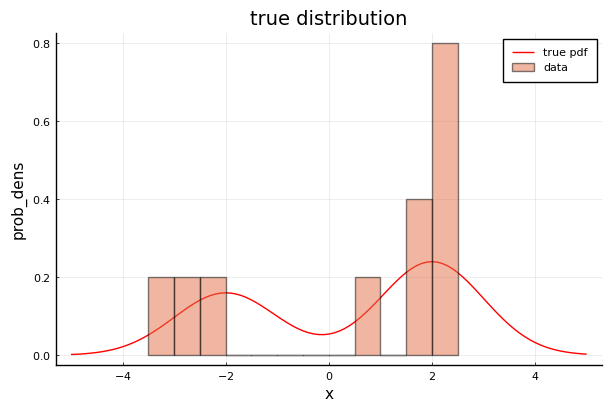

In [2]:
#set the random seed
Random.seed!(42)

#create data
a = 0.6
N = 10
μ2 = -2
σsq2 = 1
true_dist = MixtureModel(Normal[Normal(2,1), Normal(μ2,σsq2)], [a,1-a])
X = rand(true_dist, N)
data = (X=X, N=N)

#visualize
fig1 = plot(-5:0.1:5,x->pdf(true_dist,x),xlabel="x",ylabel="prob_dens",title="true distribution",
    label="true pdf", color=:red)
plot!(X, st=:histogram, bins=15, normed=true, label="data", alpha=0.5)
savefig(fig1, "figs-EP/fig1.png")

## 2. define functions

In [3]:
#normal pdf
npdf(x,μ,σsq) = pdf(Normal(μ,sqrt(σsq)), x)

#update mean and var of approximation distribution except one factor rn
function update_params_except_n(m, ssq, mn, ssqn)
    ssqtmp = 1/(1/ssq-1/ssqn)
    mtmp = m + ssqtmp*(m-mn)/ssqn
    return mtmp, ssqtmp
end

#normalizing
calcZn(xn,mtmp,ssqtmp,a,μ2,σsq2) = a*npdf(xn,mtmp,ssqtmp+1) + (1-a)*npdf(xn,μ2,σsq2)

function moment_matching(xn,mtmp,ssqtmp,a,Zn,μ2,σsq2)
    m = (a*npdf(xn,mtmp,ssqtmp+1)*((ssqtmp*xn+mtmp)/(ssqtmp+1)) + (1-a)*npdf(xn,μ2,σsq2)*mtmp)/Zn
    ssq = (a*npdf(xn,mtmp,ssqtmp+1)*(ssqtmp/(ssqtmp+1)) + (1-a)*npdf(xn,μ2,σsq2)*ssqtmp)/Zn
    return m,ssq
end

#update mean and var of factor rn
function update(m,ssq,mtmp,ssqtmp)
    ssqn = 1/(1/ssq-1/ssqtmp)
    mn = mtmp + ssqn*(m-mtmp)/ssq
    return mn,ssqn
end

#expectation propagation
function myEP(data, model_params, n_train)
    @unpack X,N = data
    @unpack μ2,σsq2,a = model_params
    
    #initialize
    mns = zeros(N); ssqns = ones(N);
    m = 0; ssq=1/(sum(1 ./ssqns)+1/100);
    
    #train loop
    @showprogress for k in 1:n_train
        #update r1,...,rN
        for n in 1:N
            mtmp, ssqtmp = update_params_except_n(m, ssq, mns[n], ssqns[n])
            Zn = calcZn(X[n],mtmp,ssqtmp,a,μ2,σsq2)
            m,ssq = moment_matching(X[n],mtmp,ssqtmp,a,Zn,μ2,σsq2)
            mns[n],ssqns[n] = update(m,ssq,mtmp,ssqtmp)
        end
    end
    return m,ssq
end

myEP (generic function with 1 method)

## 3. Estimate posterior and predictive

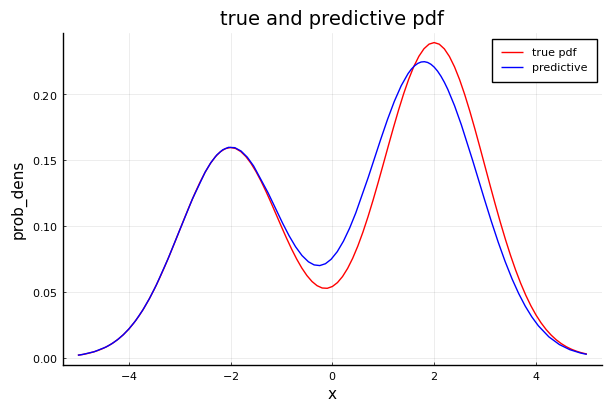

  1.603366 seconds (3.90 M allocations: 203.303 MiB, 3.33% gc time, 99.99% compilation time)
posterior mean=1.788, posterior var=0.38


In [4]:
#posterior mean and variation
n_train = 100
model_params = (μ2=μ2, σsq2=σsq2, a=a)
@time m,ssq = myEP(data, model_params, n_train)
println("posterior mean=$(round(m,digits=3)), posterior var=$(round(sqrt(ssq),digits=3))")

#model pdf
function pmodel(x, θ, model_params)
    @unpack μ2,σsq2,a = model_params
    pdf(MixtureModel(Normal[Normal(θ,1), Normal(μ2,σsq2)], [a,1-a]),x)
end

#predictive distribution
n_samps = 1000
θsamps = rand(Normal(m,sqrt(ssq)), n_samps)
function pred(x, θsamps, n_samps, model_params)
    preds = zeros(n_samps)
    for s in 1:n_samps 
        preds[s] = pmodel(x, θsamps[s], model_params)
    end
    return mean(preds)
end

#visualize
fig2 = plot(-5:0.1:5,x->pdf(true_dist,x),xlabel="x",ylabel="prob_dens",title="true and predictive pdf",
    label="true pdf", color=:red)
plot!(x->pred(x, θsamps, n_samps, model_params), color=:blue, label="predictive")
savefig(fig2, "figs-EP/fig2.png")